In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline

#### Input params ##################
stk_path = "E:\\VTI.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [2]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:

df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2019-02-07,139.179993,139.490005,137.119995,138.830002,136.205795,5097500,2
1,2019-02-08,138.139999,138.990005,137.660004,138.970001,136.343155,2105800,2
2,2019-02-11,139.399994,139.550003,138.889999,139.259995,136.627670,2337000,2
3,2019-02-12,140.119995,141.179993,140.059998,141.000000,138.334793,3312300,2
4,2019-02-13,141.449997,141.880005,141.139999,141.440002,138.766464,2369300,2
5,2019-02-14,140.860001,141.809998,140.389999,141.190002,138.521194,2731400,2
6,2019-02-15,142.160004,142.770004,141.910004,142.740005,140.041885,2537600,2
7,2019-02-19,142.410004,143.389999,142.339996,143.020004,140.316605,2469900,2
8,2019-02-20,143.050003,143.529999,142.740005,143.320007,140.610931,2357400,2
9,2019-02-21,143.059998,143.139999,142.250000,142.830002,140.130203,3684900,2


Text(0, 0.5, 'USD')

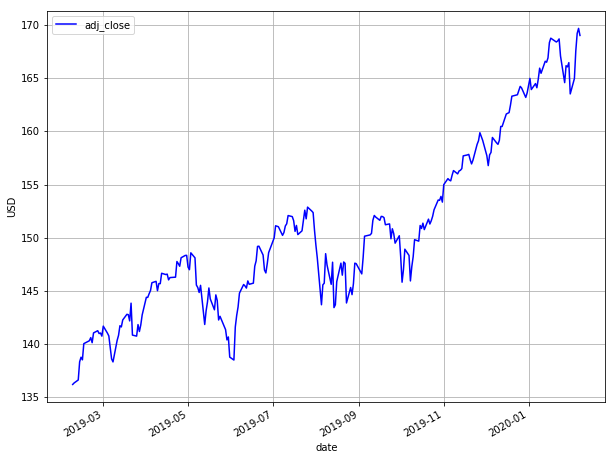

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [5]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 153
num_cv = 50
num_test = 50
train.shape = (153, 8)
cv.shape = (50, 8)
train_cv.shape = (203, 8)
test.shape = (50, 8)


Text(0, 0.5, 'USD')

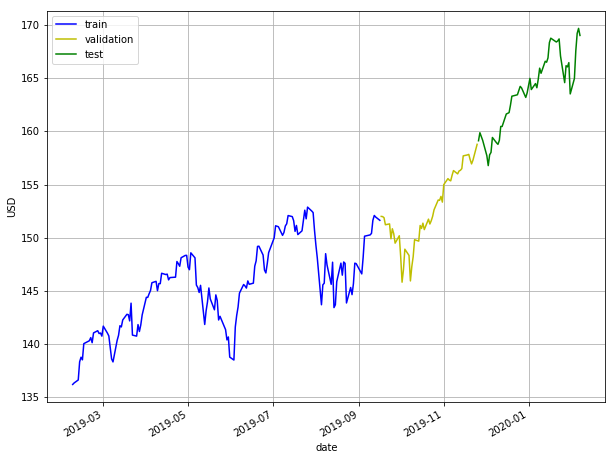

In [6]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [7]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [0.9471702389032333, 1.049204240202146, 1.1119915360752703, 1.1618046892197291, 1.2600611960770618, 1.373685836593908, 1.4941399834794953, 1.614108080897172, 1.7311827815789467, 1.8443678212723877, 1.9532406354616676, 2.0594918875492048, 2.166696329631609, 2.2724011164611175, 2.3722885907632927, 2.470282332700219, 2.5620068347098663, 2.6469423436873893, 2.7257602354309465, 2.79285210499821, 2.8537102742874105]
MAPE = [0.4749282792781118, 0.48235839730470154, 0.5536682531020164, 0.5864341828335424, 0.6509963483559724, 0.7295606611603731, 0.817400614079917, 0.9005522511388333, 0.9827134671586323, 1.0610277843468687, 1.1380901092852405, 1.212689184118932, 1.2900113080679034, 1.360233856079229, 1.4215990904158669, 1.4810057215436376, 1.5339496770274565, 1.575591518550971, 1.6122946026783385, 1.652464767156007, 1.685442145062182]


,date,open,high,low,close,adj_close,volume,month
0,2019-02-07,139.179993,139.490005,137.119995,138.830002,136.205795,5097500,2
1,2019-02-08,138.139999,138.990005,137.660004,138.970001,136.343155,2105800,2
2,2019-02-11,139.399994,139.550003,138.889999,139.259995,136.627670,2337000,2
3,2019-02-12,140.119995,141.179993,140.059998,141.000000,138.334793,3312300,2
4,2019-02-13,141.449997,141.880005,141.139999,141.440002,138.766464,2369300,2


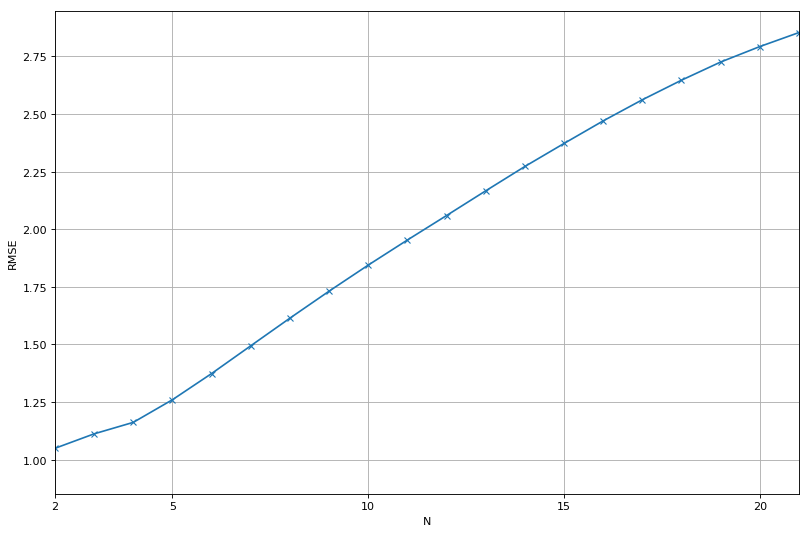

In [8]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0x1ab9e0932e8>,
 <a list of 5 Text xticklabel objects>)

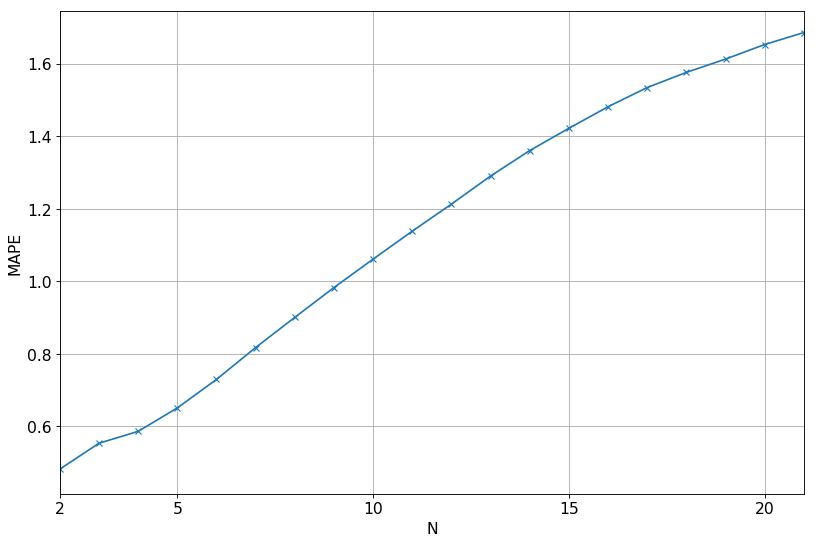

In [9]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [10]:
# Set optimum N
N_opt = 2

Text(0, 0.5, 'USD')

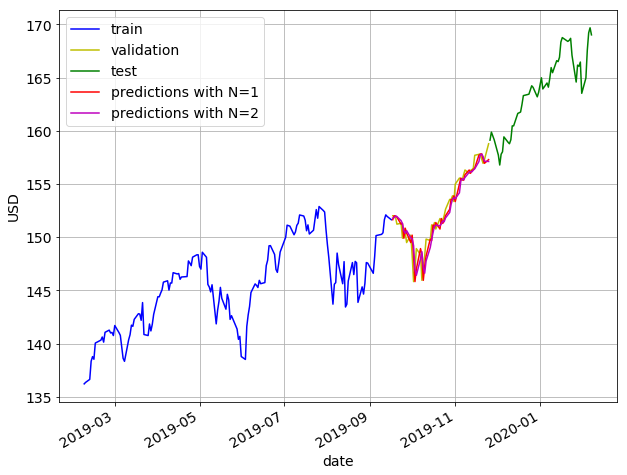

In [11]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [12]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 1.210
MAPE = 0.539%


,date,open,high,low,close,adj_close,volume,month,est_N2
203,2019-11-26,159.669998,160.059998,159.479996,159.979996,159.117233,1884900,11,158.033119
204,2019-11-27,160.380005,160.740005,160.020004,160.740005,159.873154,2343200,11,158.948150
205,2019-11-29,160.460007,160.550003,159.919998,160.020004,159.157028,1171000,11,159.495193
206,2019-12-02,160.259995,160.360001,158.449997,158.570007,157.714859,3766700,12,159.515091
207,2019-12-03,157.089996,157.710007,156.380005,157.630005,156.779922,4040300,12,158.435944


Text(0, 0.5, 'USD')

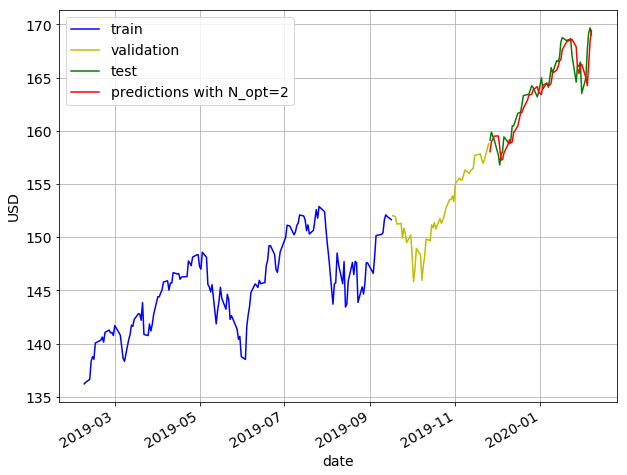

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")